In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv('household_power_consumption.csv',
                 parse_dates={'dt': ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan', '?'], index_col='dt')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15200\1505060259.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.csv',
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15200\1505060259.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.csv',
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15200\1505060259.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.csv',


In [5]:
# We check if there are any missing values in the dataset.

df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [17]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

In [18]:
df_resampled = df.resample('h').mean()


In [19]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_resampled)

In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_len]
        y = self.data[index + self.seq_len, 0]
        return torch.tensor(x).float(), torch.tensor(y).float()

In [21]:
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [22]:
seq_len = 24  # Sequence length

train_dataset = TimeSeriesDataset(train_data, seq_len)
test_dataset = TimeSeriesDataset(test_data, seq_len)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [24]:
input_size = 7  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0068
Epoch [2/10], Loss: 0.0081
Epoch [3/10], Loss: 0.0083
Epoch [4/10], Loss: 0.0072
Epoch [5/10], Loss: 0.0076
Epoch [6/10], Loss: 0.0059
Epoch [7/10], Loss: 0.0085
Epoch [8/10], Loss: 0.0091
Epoch [9/10], Loss: 0.0052
Epoch [10/10], Loss: 0.0074


In [26]:
model.eval()
predictions = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)

In [27]:
dummy = np.zeros((len(predictions), data_scaled.shape[1]))

dummy[:, 0] = predictions.ravel()

predictions_original_scale = scaler.inverse_transform(dummy)[:, 0]
dummy_test = np.zeros((len(test_data) - seq_len, data_scaled.shape[1]))
dummy_test[:, 0] = test_data[seq_len:, 0]
true_values_original_scale = scaler.inverse_transform(dummy_test)[:, 0]

In [28]:
mae = mean_absolute_error(true_values_original_scale, predictions_original_scale)
mse = mean_squared_error(true_values_original_scale, predictions_original_scale)

print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

MAE: 0.3532
MSE: 0.2403


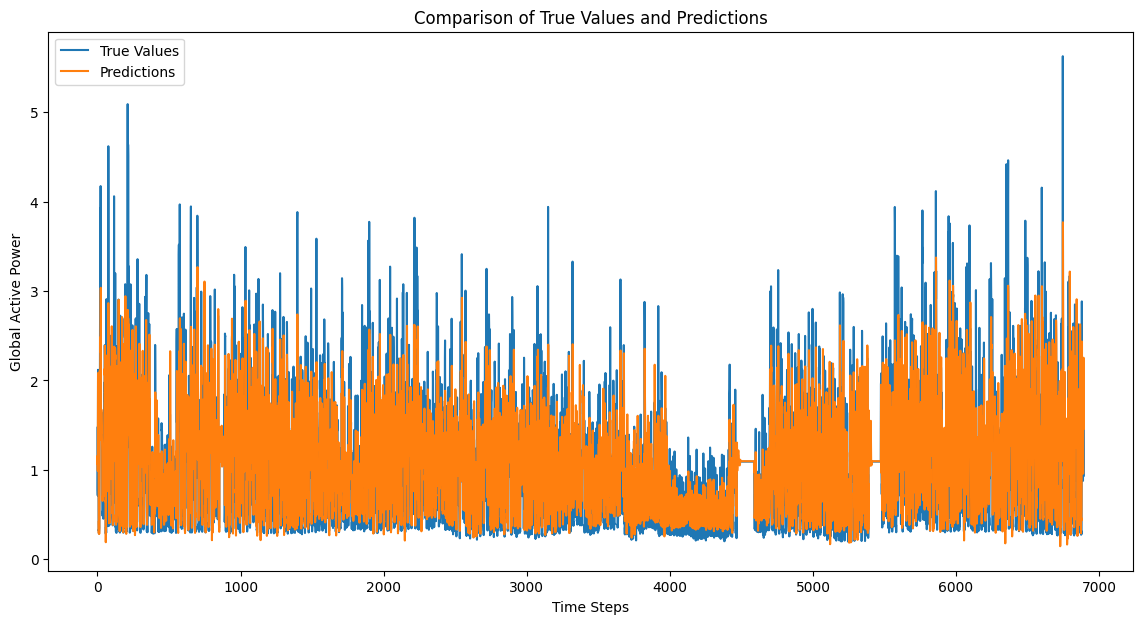

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(true_values_original_scale, label='True Values')
plt.plot(predictions_original_scale, label='Predictions')
plt.title('Comparison of True Values and Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [31]:
model_lstm = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model_lstm(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0065
Epoch [2/10], Loss: 0.0077
Epoch [3/10], Loss: 0.0110
Epoch [4/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0100
Epoch [6/10], Loss: 0.0077
Epoch [7/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0065
Epoch [9/10], Loss: 0.0077
Epoch [10/10], Loss: 0.0082


LSTM MAE: 0.3329
LSTM MSE: 0.2331


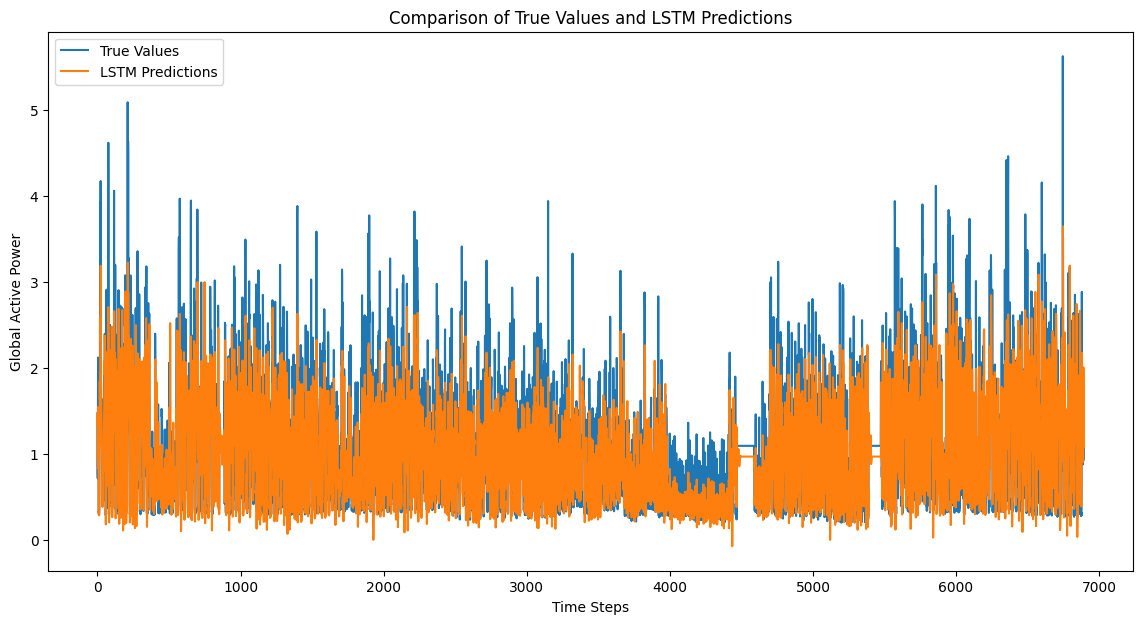

In [32]:
model_lstm.eval()
predictions_lstm = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model_lstm(batch_x)
        predictions_lstm.append(outputs.cpu().numpy())

predictions_lstm = np.concatenate(predictions_lstm, axis=0)

dummy_lstm = np.zeros((len(predictions_lstm), data_scaled.shape[1]))
dummy_lstm[:, 0] = predictions_lstm.ravel()
predictions_lstm_original_scale = scaler.inverse_transform(dummy_lstm)[:, 0]

mae_lstm = mean_absolute_error(true_values_original_scale, predictions_lstm_original_scale)
mse_lstm = mean_squared_error(true_values_original_scale, predictions_lstm_original_scale)

print(f'LSTM MAE: {mae_lstm:.4f}')
print(f'LSTM MSE: {mse_lstm:.4f}')

plt.figure(figsize=(14, 7))
plt.plot(true_values_original_scale, label='True Values')
plt.plot(predictions_lstm_original_scale, label='LSTM Predictions')
plt.title('Comparison of True Values and LSTM Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()